In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch, AsinhStretch


In [2]:
def map_blocks_adresses(raw, column):
    """
    Maps the adresses of the individual blocks from a given raw and column identifier of the 4x8 matrix to the corresponding mosaic identifier (1 to 32) given the following convention

    |32|31|30|29|16|15|14|13|
    |28|27|26|25|12|11|10| 9|
    |24|23|22|21| 8| 7| 6| 5|
    |20|19|18|17| 4| 3| 2| 1|

    Parameters
    ----------
    raw    : [int]
    column : [int]

    Return
    ----------
    [int] address of the block in the mosaic given the raw and column identifier
    """
    raw_colomn_id = '(%i,%i)' % (raw, column)
    if raw_colomn_id == '(3,0)':
        return 0
    if raw_colomn_id == '(3,1)':
        return 1
    if raw_colomn_id == '(3,2)':
        return 2
    if raw_colomn_id == '(3,3)':
        return 3
    if raw_colomn_id == '(2,0)':
        return 4
    if raw_colomn_id == '(2,1)':
        return 5
    if raw_colomn_id == '(2,2)':
        return 6
    if raw_colomn_id == '(2,3)':
        return 7
    if raw_colomn_id == '(1,0)':
        return 8
    if raw_colomn_id == '(1,1)':
        return 9
    if raw_colomn_id == '(1,2)':
        return 10
    if raw_colomn_id == '(1,3)':
        return 11
    if raw_colomn_id == '(0,0)':
        return 12
    if raw_colomn_id == '(0,1)':
        return 13
    if raw_colomn_id == '(0,2)':
        return 14
    if raw_colomn_id == '(0,3)':
        return 15
    if raw_colomn_id == '(3,4)':
        return 16
    if raw_colomn_id == '(3,5)':
        return 17
    if raw_colomn_id == '(3,6)':
        return 18
    if raw_colomn_id == '(3,7)':
        return 19
    if raw_colomn_id == '(2,4)':
        return 20
    if raw_colomn_id == '(2,5)':
        return 21
    if raw_colomn_id == '(2,6)':
        return 22
    if raw_colomn_id == '(2,7)':
        return 23
    if raw_colomn_id == '(1,4)':
        return 24
    if raw_colomn_id == '(1,5)':
        return 25
    if raw_colomn_id == '(1,6)':
        return 26
    if raw_colomn_id == '(1,7)':
        return 27
    if raw_colomn_id == '(0,4)':
        return 28
    if raw_colomn_id == '(0,5)':
        return 29
    if raw_colomn_id == '(0,6)':
        return 30
    if raw_colomn_id == '(0,7)':
        return 31

In [3]:
def get_raw_image(filename):
    """
    Retrieve the mosaic from the fits file. The final list
    contains the 32 fits images.

    Parameters
    ----------
    filename : [str] name of the file

    Return
    ----------
    raw_images    : [numpy.array(np.float32)] unscaled mosaic
    header        : [astropy.io.fits.hdu.image.PrimaryHDU] header info
    """
    hdul = fits.open(filename)
    raw_images = []
    header = hdul[0].header
    for i in range(1, len(hdul)):
        raw_images.append(hdul[i].data)
    hdul.close()
    return raw_images[::-1], header


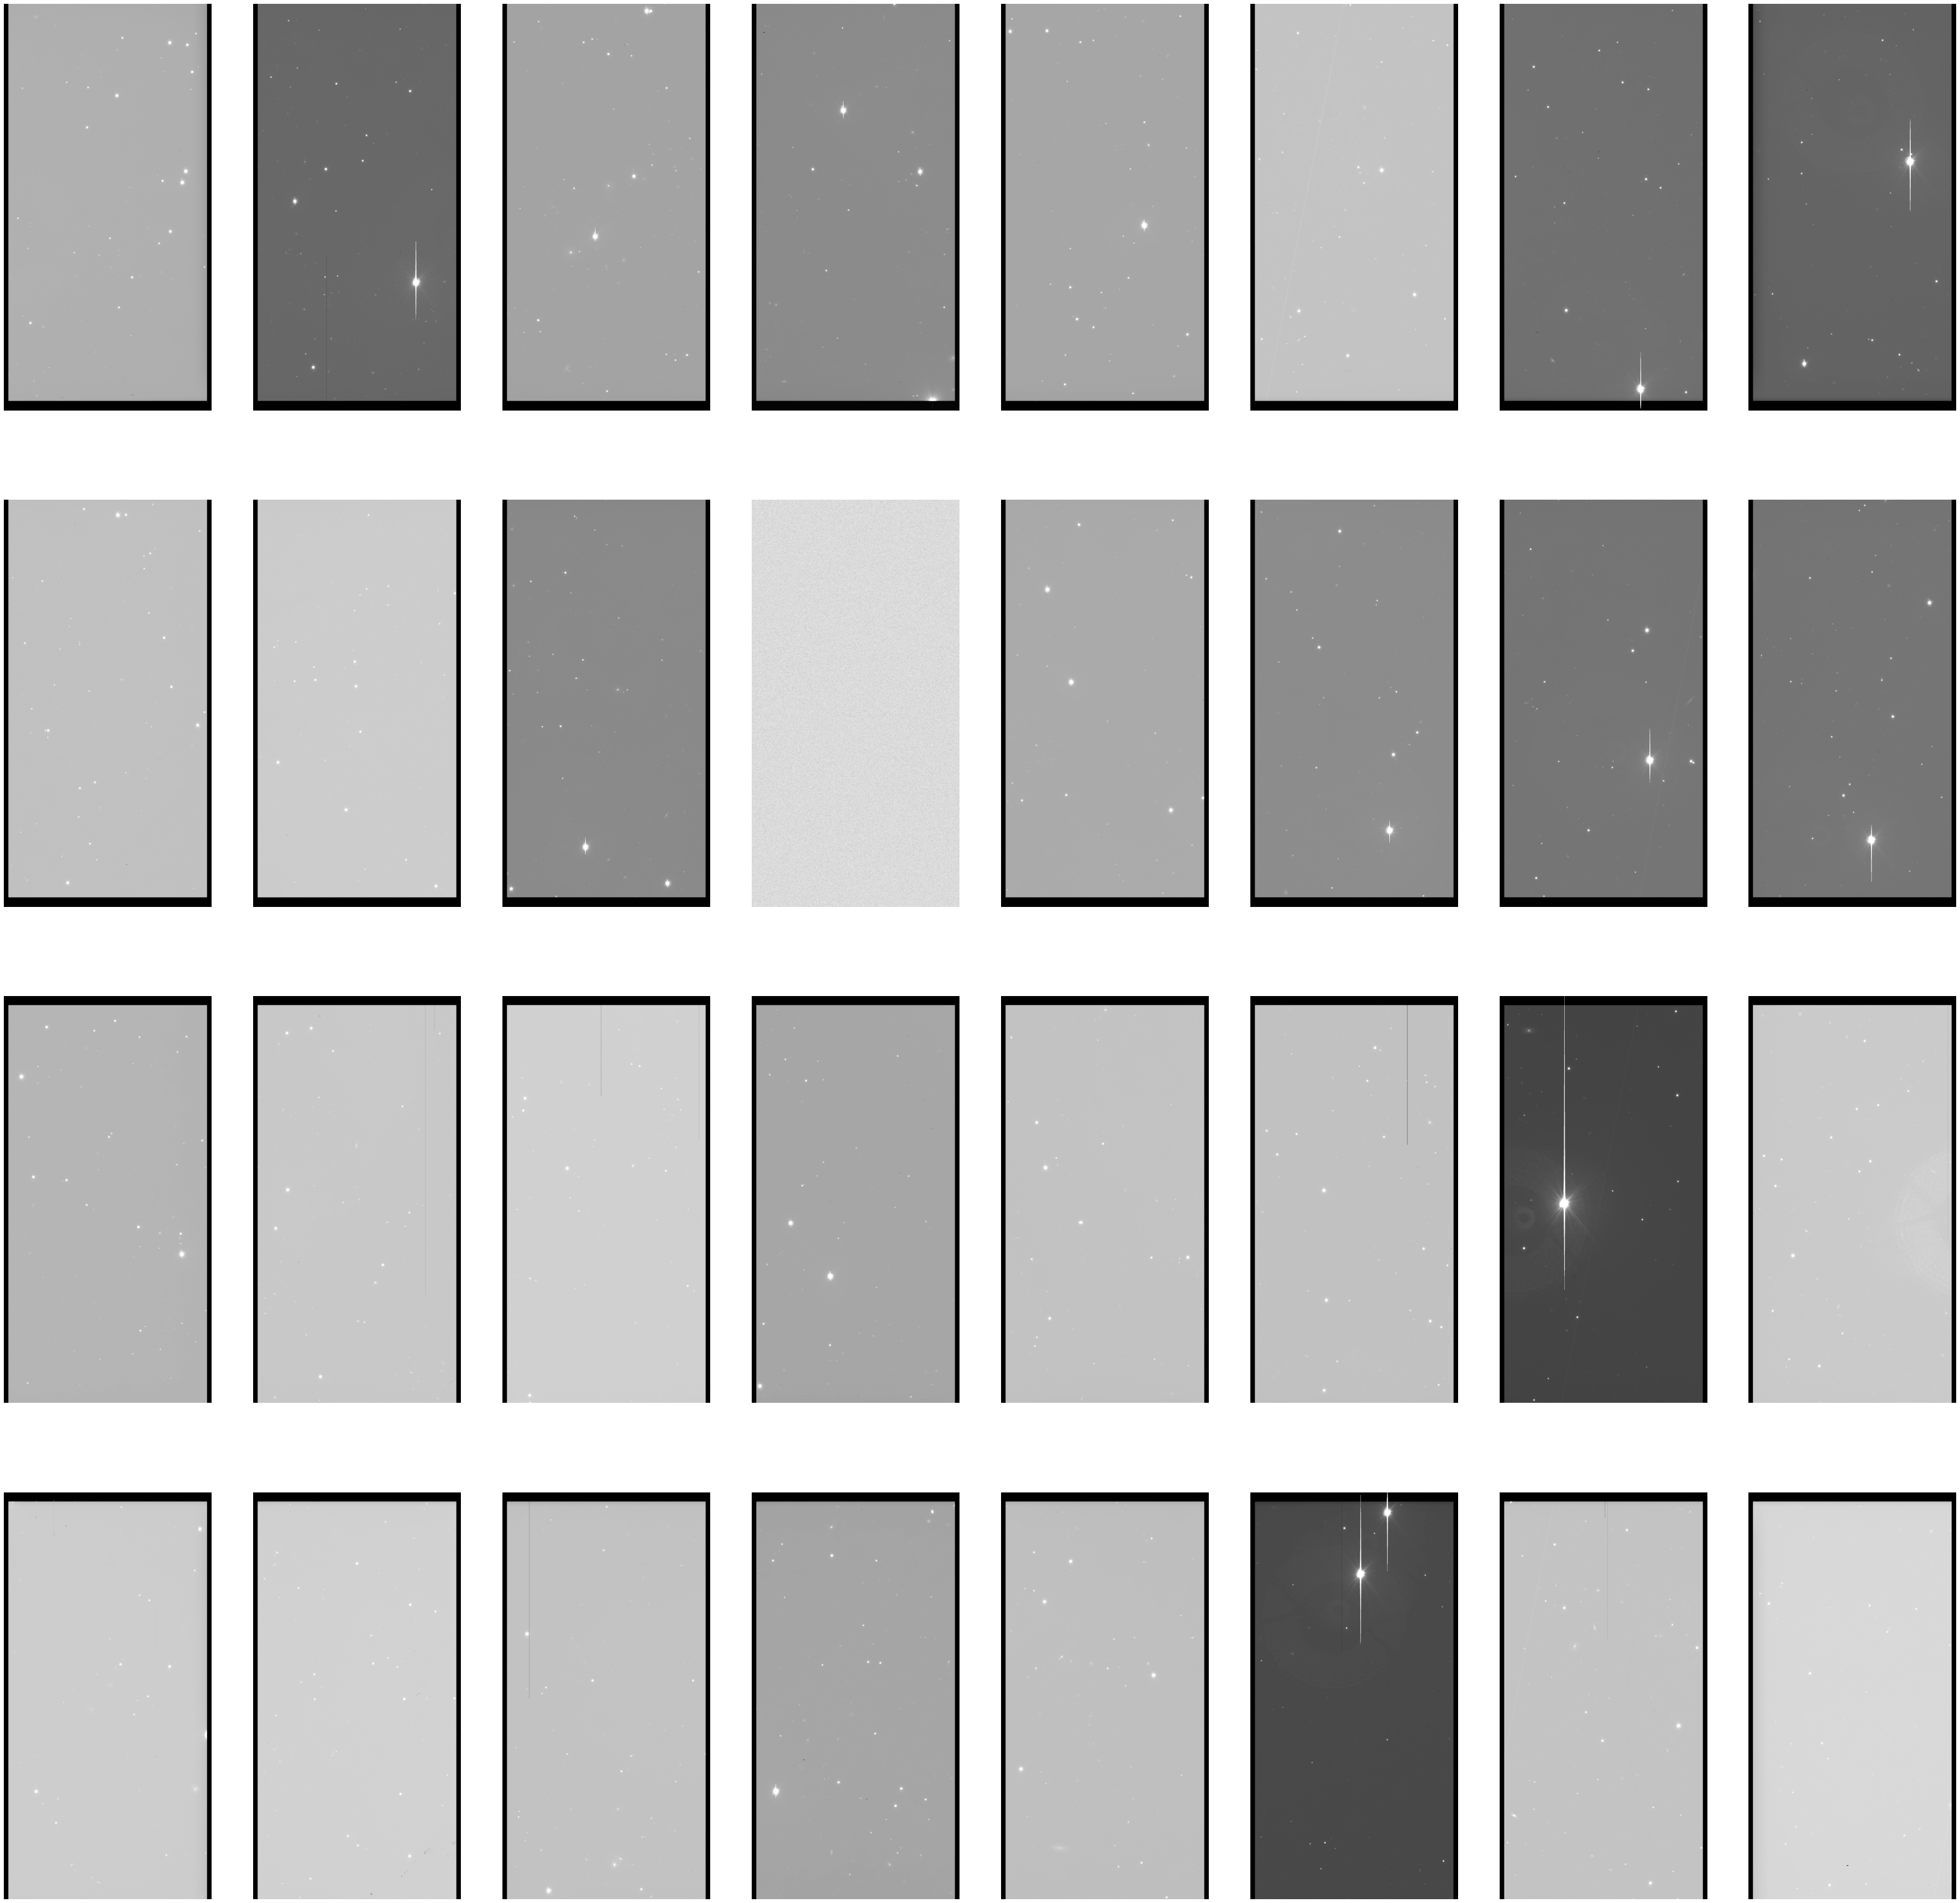

In [4]:
# plot all tiles

raw_images, header = get_raw_image(
    '../VST/images/OMEGA.2020-12-02T00_52_12.580.fits')
f, axes = plt.subplots(4, 8, figsize=(64, 64))
for i in range(4):
    for j in range(8):
        img = raw_images[map_blocks_adresses(i, j)]
        #crop_img, crop_results = post_results
        norm = ImageNormalize(stretch=AsinhStretch())
        m = np.mean(img)
        s = np.std(img)
        img[img < m-s] = 0
        img[img > m+3*s] = m+3*s
        axes[i, j].imshow(img, norm=norm, cmap='gray')
        axes[i, j].axis('off')

In [5]:
def create_mosaic(path, field_name, obs_date):

    import matplotlib.pyplot as plt
    import glob
    import numpy as np
    from astropy.wcs import WCS
    import glob
    import astropy.io.fits as fits
    import os
    from astropy.time import Time
    from datetime import datetime, timedelta

    from reproject import reproject_interp
    from reproject.mosaicking import reproject_and_coadd
    from reproject.mosaicking import find_optimal_celestial_wcs

    middlelink = '/obs/lenses_EPFL/PRERED/VST/reduced/' + field_name + '/'
    allothers = '/obs/lenses_EPFL/PRERED/VST/reduced/' + field_name + '_wide_field/'

    #middlelink = './data2/'
    #allothers = './data3/'

    obsdate = obs_date #corrected for LST difference
    date = datetime.strftime(datetime.strptime(obsdate, '%Y-%m-%d')-timedelta(days=1), '%Y-%m-%d')

    finalseepoch = np.sort(glob.glob(allothers+'*'+obsdate+'*.fits')) #[:1]
    eachtimes = np.unique([epochname.split(obsdate)[1].split('_')[0] for epochname in finalseepoch])
    coadd = fits.open(glob.glob(middlelink+'/mosaic/*'+date+'*.fits')[0])
    names = []

    for aaa in range(len(eachtimes)):

        singleepochs = glob.glob(allothers+'*'+obsdate+eachtimes[aaa]+'*.fits')
        finalchip = glob.glob(middlelink+'*'+obsdate+eachtimes[aaa]+'*.fits')
        allepochs = np.array(finalchip+list(singleepochs))

        #allepochs  = glob.glob(allothers+'/*')

        all_hdus = []
        for epoch in allepochs:
            all_hdus.append(fits.open(epoch)[0])

        #array, footprint = reproject_interp(hdu2, coadd.header)
        print(all_hdus)
        from astropy import units as u
        wcs_out, shape_out = find_optimal_celestial_wcs(all_hdus, resolution=2.14 * u.arcsec)
        print(wcs_out)
        array, footprint = reproject_and_coadd(all_hdus, wcs_out, shape_out=shape_out,
                                               reproject_function=reproject_interp)

        datestring = [allepochs[0].split('/')[-1].split('_')[0][6:]]
        starttime = Time(datestring, format='isot', scale='utc').mjd[0]
        exptime = all_hdus[0].header['EXPTIME']/(24.*3600.)
        endtime = starttime+exptime

        header = wcs_out.to_header()
        primary_hdu = fits.PrimaryHDU(array, header=header)
        primary_hdu.header['STARTMJD'] = starttime
        primary_hdu.header['ENDMJD'] = endtime

        #hdu = fits.ImageHDU(array)

        hdul = fits.HDUList([primary_hdu])

        name = allepochs[0].split('/')[-1].split('_')[0]+'_fullfield_binned.fits'
        hdul.writeto(path+name, overwrite=True)

        names.append(name)

    return names

In [6]:
# open image
filename = "../VST/images/OMEGA.2020-12-02T00_52_12.580.fits"
hdul = fits.open(filename)
shape_one_tile = np.shape(hdul[1].data)
raw_images, header = get_raw_image(filename)
full_image = np.zeros((4*shape_one_tile[0], 8*shape_one_tile[1])) # create matrix for all tiles together
for i in range(4):
    for j in range(8):
        img = raw_images[map_blocks_adresses(i, j)]
        #crop_img, crop_results = post_results
        full_image[i*shape_one_tile[0]:(i+1)*shape_one_tile[0], j*shape_one_tile[1]:(j+1)*shape_one_tile[1]] = img


In [8]:
# save file to new fits image
hdu = fits.PrimaryHDU(full_image)
hdu.writeto('new1.fits', overwrite=True)


In [9]:
# manual scaling
m = np.mean(full_image)
s = np.std(full_image)
max_value = 2**16 - 1
full_image[full_image < m-3*s] = m-3*s
m = np.mean(full_image)
s = np.std(full_image)
full_image[full_image > m+2*s] = m+2*s
full_image *= max_value/(m+2*s)
norm = ImageNormalize(stretch=AsinhStretch())

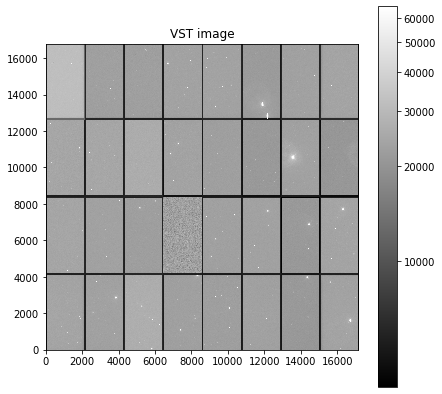

In [10]:
# show full image
plt.figure(figsize=(7, 7))
plt.title('VST image')
plt.imshow(full_image, origin='lower', cmap='gray', interpolation='none', norm=norm)
plt.colorbar()
plt.show()


Text(0, 0.5, 'Occurences')

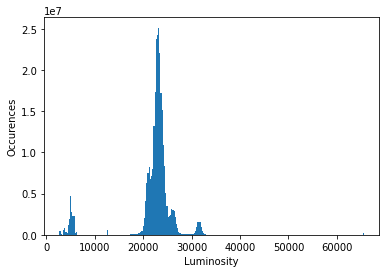

In [11]:
# histogramm of image
plt.figure()
plt.hist(full_image.flatten(), bins=256)
plt.xlabel('Luminosity')
plt.ylabel('Occurences')